#import library

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## load & show image

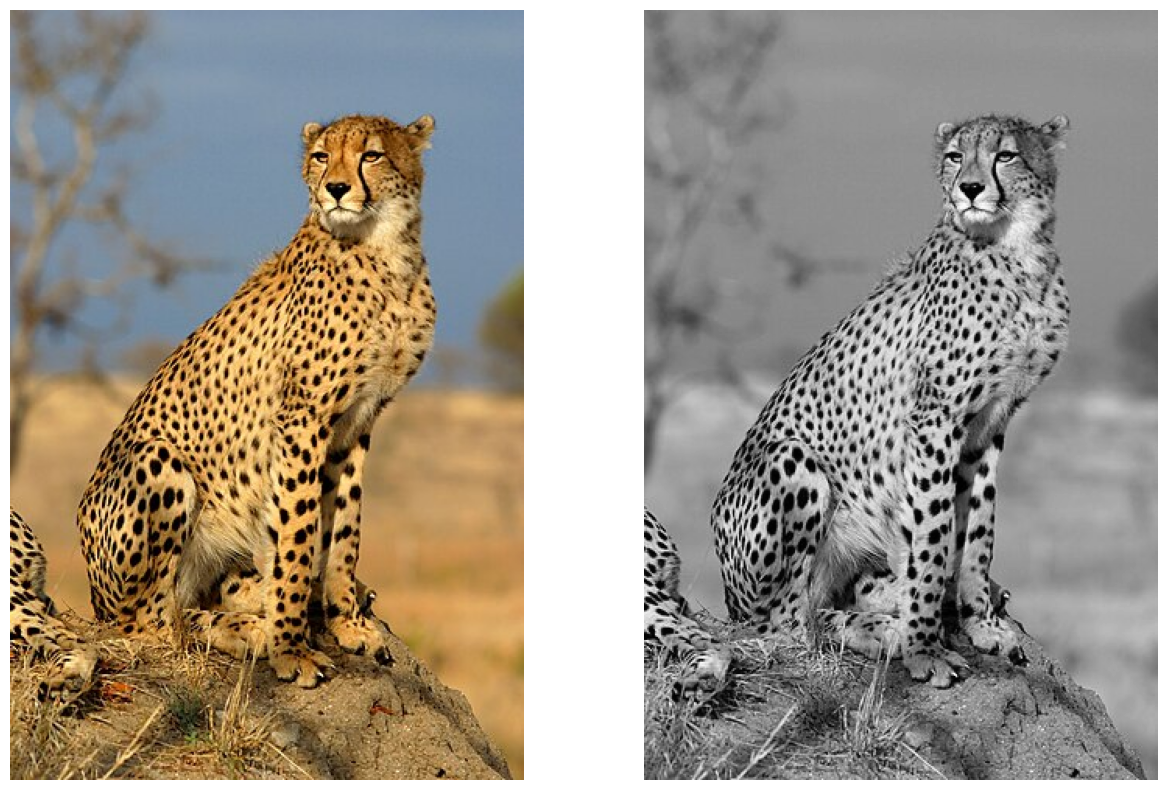

In [2]:
img = np.array(Image.open('TheCheethcat.jpg')).astype(np.uint8)

gray_img = np.round(0.299 * img[:, :, 0] +
                    0.587 * img[:, :, 1] +
                    0.114 * img[:, :, 2]).astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gray_img, cmap='gray')
plt.axis('off')

plt.show()

#Sobel Operator


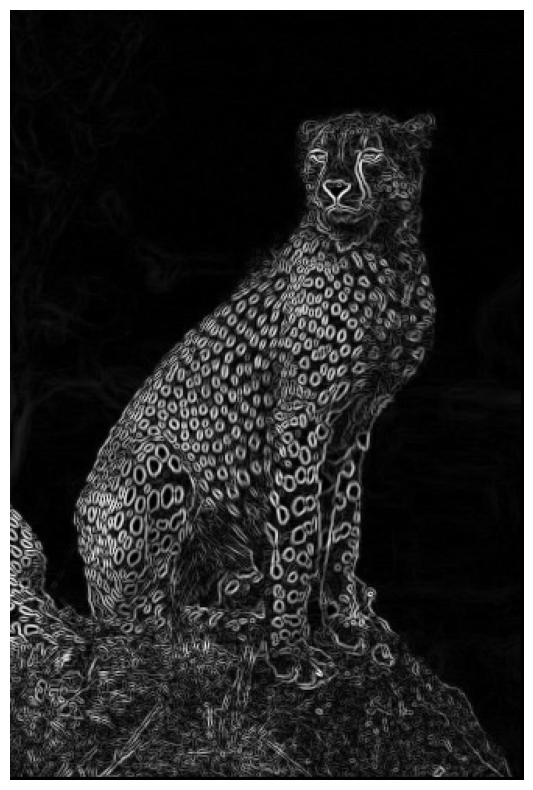

In [3]:
# Sobel Operator
h, w = gray_img.shape

# Define Sobel filters

horizontal = np.array([[-1, 0, 1],
                       [-2, 0, 2],
                       [-1, 0, 1]])
vertical = np.array([[-1, -2, -1],
                     [0, 0, 0],
                     [1, 2, 1]])

newhorizontalImage = np.zeros((h, w))
newverticalImage = np.zeros((h, w))
newgradientImage = np.zeros((h, w))


for i in range(1, h - 1):
    for j in range(1, w - 1):

        #Apply horizontal Sobel filters using convolution over 3x3 neighborhoods
        horizontalGrad = np.sum(np.multiply(gray_img[i-1: i+2, j-1: j+2], horizontal))

        newhorizontalImage[i - 1, j - 1] = abs(horizontalGrad)

        #Apply vertical Sobel filters using convolution over 3x3 neighborhoods
        verticalGrad = np.sum(np.multiply(gray_img[i-1: i+2, j-1: j+2], vertical))

        newverticalImage[i - 1, j - 1] = abs(verticalGrad)

        # Edge Magnitude
        mag = np.sqrt(horizontalGrad**2 + verticalGrad**2)
        newgradientImage[i - 1, j - 1] = mag


plt.figure(figsize=(15, 10))
plt.imshow(newgradientImage, cmap='gray')
plt.axis('off')
plt.show()

#Prewitt Operator


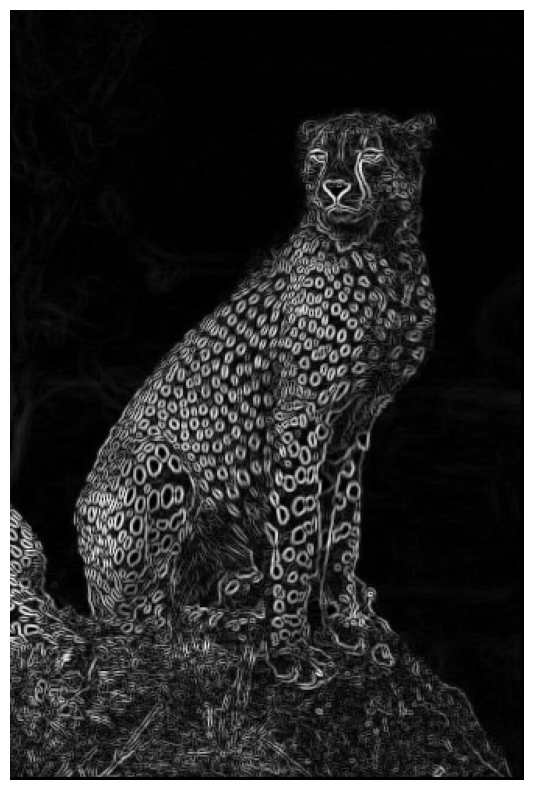

In [4]:
# Prewitt Operator
h, w = gray_img.shape

# Define Prewitt filters
horizontal = np.array([[-1, 0, 1],
                       [-1, 0, 1],
                       [-1, 0, 1]])
vertical = np.array([[-1, -1, -1],
                     [0, 0, 0],
                     [1, 1, 1]])


newgradientImage = np.zeros((h, w))


for i in range(1, h - 1):
    for j in range(1, w - 1):
        # Similar to Sobel, apply horizontal and vertical Prewitt filters and compute gradient magnitude
        horizontalGrad = np.sum(np.multiply(gray_img[i-1: i+2, j-1: j+2], horizontal))
        verticalGrad = np.sum(np.multiply(gray_img[i-1: i+2, j-1: j+2], vertical))

        # Edge Magnitude
        mag = np.sqrt(horizontalGrad**2 + verticalGrad**2)
        newgradientImage[i - 1, j - 1] = mag

plt.figure(figsize=(15, 10))
plt.imshow(newgradientImage, cmap='gray')
plt.axis('off')
plt.show()

#Canny Operator


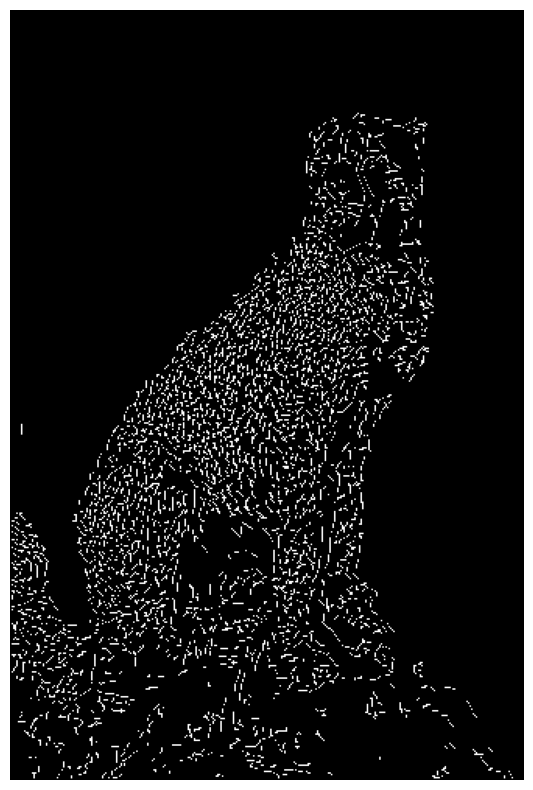

In [5]:
from scipy.ndimage import gaussian_filter, sobel

gray_img = Image.open('TheCheethcat.jpg').convert('L')
gray_img = np.array(gray_img, dtype=np.float32)

blurred = gaussian_filter(gray_img, sigma=1.4)


dx = sobel(blurred, axis=0)
dy = sobel(blurred, axis=1)
gradient_magnitude = np.hypot(dx, dy)
gradient_direction = np.arctan2(dy, dx)


def non_maximum_suppression(magnitude, direction):
    rows, cols = magnitude.shape
    suppressed = np.zeros((rows, cols), dtype=np.float32)
    # 1. Convert direction to degrees (0-180 range)
    # 2. For each pixel, compare magnitude with neighbors along gradient direction
    # 3. Suppress non-maximum values (set to 0)
    # Hint: Check 4 direction bins (0°, 45°, 90°, 135°) and compare with appropriate neighbors

    #######
    direction[direction < 0 ] += np.pi
    dir = [(0, 1), (-1, 1), (-1, 0), (-1, -1), (-1, -1)]
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            proper_dir = int((4 * direction[i, j]) // np.pi)
            delta_x, delta_y = dir[proper_dir]
            if (magnitude[i, j] >= magnitude[i+delta_x, j+delta_y]) and (magnitude[i,j] >= magnitude[i-delta_x, j-delta_y]):
                suppressed[i, j] = magnitude[i, j]
            else:
                suppressed[i, j] = 0
    ######

    return suppressed

nms_img = non_maximum_suppression(gradient_magnitude, gradient_direction)


low_threshold = 50
high_threshold = 100


# Apply double thresholding
# Steps:
# 1. Mark strong edges as 255
# 2. Mark weak edges as 75
strong_edges = np.zeros_like(nms_img)
strong_edges[nms_img >= high_threshold] = 255
weak_edges = np.zeros_like(nms_img)
weak_edges[(nms_img >= low_threshold) & (nms_img < high_threshold)] = 75


def hysteresis(strong, weak):
    rows, cols = strong.shape

    check = np.zeros_like(strong) # for bfs
    def bfs(v):
        queue = [v]
        check[v] = 1
        while(len(queue) != 0):
            x_v, y_v = queue.pop(0)####
            for i in range(x_v - 1, x_v + 2):
                for j in range(y_v - 1, y_v + 2):
                    if i >= 0 and i < rows and j >= 0 and j < cols:
                        if (weak[i, j]) or (not check[i, j] and strong[i, j]):
                            check[i, j] = 1
                            queue.append((i, j))#####
                            weak[i, j] = 0
                            strong[i, j] = 255

    

    for i in range(0, rows):
        for j in range(0, cols):
            if strong[i, j] and not check[i, j]:
                bfs((i, j))

    return strong

edges = hysteresis(strong_edges, weak_edges)


plt.figure(figsize=(15, 10))
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()


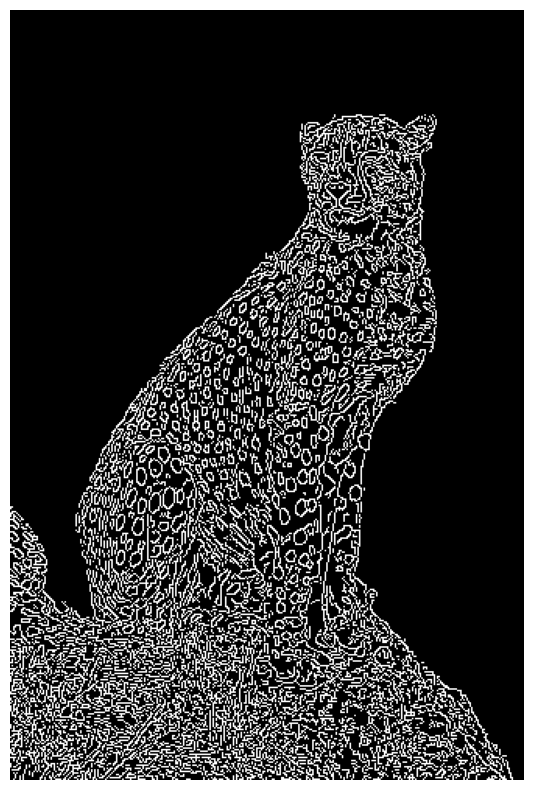

In [6]:
import cv2
import matplotlib.pyplot as plt

# Open the image
img = cv2.imread('TheCheethcat.jpg')


# Apply Canny
# Use cv2.Canny with the following parameters:
# - Low threshold (e.g., 100)
# - High threshold (e.g., 200)
# - Aperture size for Sobel operator (e.g., 3)
edges = cv2.Canny(img, 100, 200, apertureSize=3)

plt.figure(figsize=(15, 10))
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()